# Zero-shot Classification with Stable Diffusion

In [57]:
# !pip install -Uq diffusers transformers fastcore torch matplotlib fastdownload img2vec_pytorch fastai

## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [2]:
from PIL import Image
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

/home/seb.derhy/anaconda3/envs/sdv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [4]:
!nvidia-smi

Thu Nov 24 20:46:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P5    14W / 250W |     84MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [5]:
torch.cuda.set_device(0)

### Image to Image Pipeline

Even though Stable Diffusion was trained to generate images, and optionally drive the generation using text conditioning, we can use the raw image diffusion process for other tasks.

For example, instead of starting from pure noise, we can start from an image an add a certain amount of noise to it. We are replacing the initial steps of the denoising and pretending our image is what the algorithm came up with. Then we continue the diffusion process from that state as usual.

This usually preserves the composition although details may change a lot. It's great for sketches!

These operations (provide an initial image, add some noise to it and run diffusion from there) can be automatically performed by a special image to image pipeline: `StableDiffusionImg2ImgPipeline`. This is the source code for its [`__call__` method](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py#L124).

In [6]:
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload
from PIL import ImageOps

In [7]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 23522.21it/s]


In [11]:
num_photos_per_lbl = 2

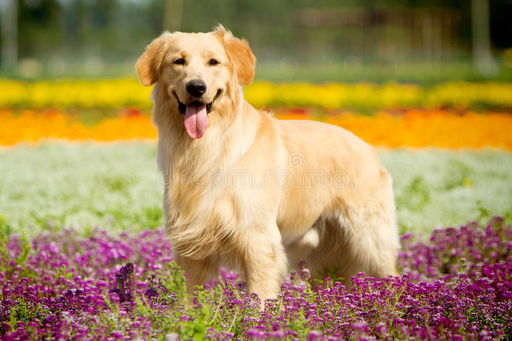

In [12]:
p = FastDownload().download('https://thumbs.dreamstime.com/b/golden-retriever-dog-21668976.jpg')
init_image = Image.open(p).convert("RGB")
init_image = ImageOps.contain(init_image, (512,512))
init_image

In [13]:
prompts = ["A photo of a dog", "A photo of a cat"]
images = pipe(prompt=prompts, num_images_per_prompt=num_photos_per_lbl,
              init_image=init_image, strength=0.8, num_inference_steps=50).images

100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


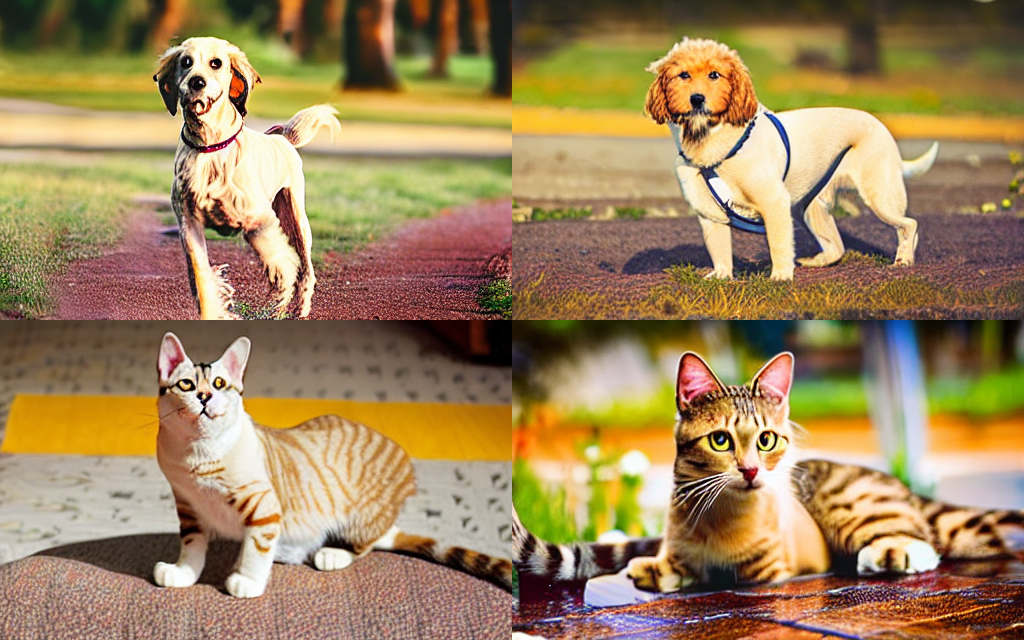

In [14]:
image_grid(images, rows=2, cols=num_photos_per_lbl)

I will use here [this very cool library](https://github.com/christiansafka/img2vec) to easily do image embedding using a standard off-the-shelf NN

In [15]:
from img2vec_pytorch import Img2Vec
img2vec = Img2Vec(cuda=True, model="resnet-18")
cosine_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

/home/seb.derhy/anaconda3/envs/sdv2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seb.derhy/anaconda3/envs/sdv2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Read in an image (rgb format)
# Get a vector from img2vec, returned as a torch FloatTensor
vec = img2vec.get_vec(init_image, tensor=True).squeeze()
vec.shape

torch.Size([512])

In [17]:
vecs1 = torch.Tensor(img2vec.get_vec(images[:num_photos_per_lbl]).squeeze())
vecs2 = torch.Tensor(img2vec.get_vec(images[num_photos_per_lbl:]).squeeze())

In [18]:
cosine_sim(vec, vec+0.1)

tensor(0.9984)

In [19]:
cosine_sim(vecs1.mean(dim=0), vec), cosine_sim(vecs2.mean(dim=0), vec)

(tensor(0.8000), tensor(0.6207))

In [21]:
@torch.no_grad()
def score_images_against_ref(imgs, ref_image):
    vecs_imgs = torch.Tensor(img2vec.get_vec(imgs).squeeze()).mean(dim=0)
    vec_ref = torch.Tensor(img2vec.get_vec(ref_image).squeeze())
    return cosine_sim(vecs_imgs, vec_ref)

In [22]:
score_images_against_ref(images[:num_photos_per_lbl], init_image), score_images_against_ref(images[num_photos_per_lbl:], init_image)

(tensor(0.8000), tensor(0.6207))

In [23]:
@torch.no_grad()
def zero_shot_classif_with_sd(img, prompts=["A photo of a dog", "A photo of a cat"], debug=False):
    img = ImageOps.contain(img.convert("RGB"), (512,512))
    images = pipe(prompt=prompts, num_images_per_prompt=num_photos_per_lbl, init_image=img,
                  strength=0.8, num_inference_steps=50).images    
    s1 = score_images_against_ref(images[:num_photos_per_lbl], img) 
    s2 = score_images_against_ref(images[num_photos_per_lbl:], img)
    
    if debug: 
        print(f"dog score: {s1}, cat score: {s2}")
    return prompts[0] if s1>s2 else prompts[1]

In [24]:
p = FastDownload().download('https://cdn.britannica.com/91/181391-050-1DA18304/cat-toes-paw-number-paws-tiger-tabby.jpg')
init_image = Image.open(p)

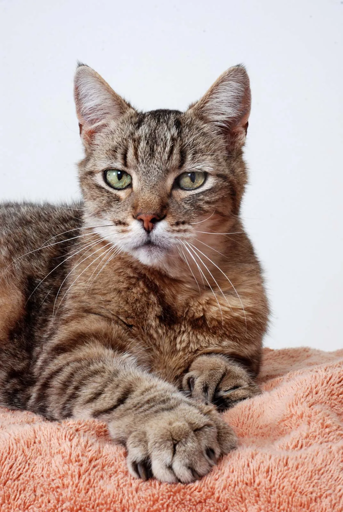

In [25]:
init_image = ImageOps.contain(init_image, (512,512))
init_image

In [26]:
zero_shot_classif_with_sd(init_image, debug=True)

100%|██████████| 41/41 [00:29<00:00,  1.38it/s]


dog score: 0.60866379737854, cat score: 0.8900543451309204


'A photo of a cat'

# Try on the dogs v cats dataset

In [47]:
@torch.no_grad()
def zero_shot_dogsvcats_sd(img, prompts=["A photo of a dog", "A photo of a cat"], 
                           num_photos_per_lbl=num_photos_per_lbl, debug=False):
    img = ImageOps.contain(img.convert("RGB"), (512,512))
    images = pipe(prompt=prompts, num_images_per_prompt=num_photos_per_lbl, init_image=img,
                  strength=0.8, num_inference_steps=50).images    
    s1 = score_images_against_ref(images[:num_photos_per_lbl], img) 
    s2 = score_images_against_ref(images[num_photos_per_lbl:], img)
    if debug: print(f"dog score: {s1}, cat score: {s2}")
    return "dog" if s1>s2 else "cat"

In [28]:
from fastai.vision.all import *

In [29]:
path = untar_data(URLs.DOGS)

In [30]:
files = get_image_files(path, folders=["valid"])

In [31]:
random.shuffle(files)

In [32]:
def label_func(x): return Path(x).stem.split(".")[0]

In [48]:
img_p = files[24]
gt = label_func(img_p)
pred = zero_shot_dogsvcats_sd(Image.open(img_p), debug=True)
gt, pred

100%|██████████| 41/41 [00:37<00:00,  1.10it/s]


dog score: 0.6905500888824463, cat score: 0.858400821685791


('cat', 'cat')

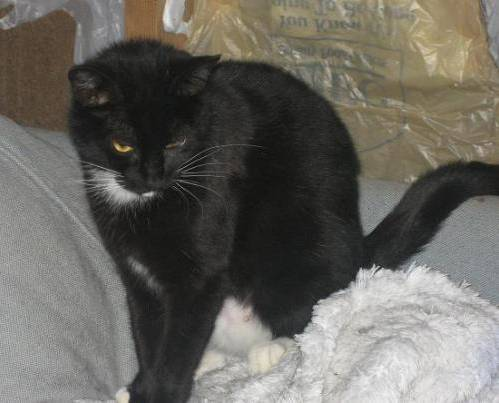

In [49]:
Image.open(img_p)

In [44]:
score = 0
N_loop = len(files) # 100
for i, img_p in enumerate(files[:N_loop]):
    gt = label_func(img_p)
    img = Image.open(img_p)
    pred = zero_shot_dogsvcats_sd(img, num_photos_per_lbl=num_photos_per_lbl)
    is_correct = (gt==pred)
    print(f"{i} -- pred: {pred}, gt: {gt}")
    score += is_correct

In [58]:
score/N_loop

0.9325

# Compare with Clip

In [60]:
from transformers import CLIPProcessor, CLIPModel
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [61]:
device = torch.device("cuda")

In [62]:
def zero_shot_dogsvcats_clip(img, debug=False):
    inputs = processor(text=["A photo of a dog", "A photo of a cat"], images=[img],
                   return_tensors="pt", padding=True)
    outputs = clip(**inputs.to(device))
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).squeeze()  # we can take the softmax to get the label probabilities
    if debug: 
        print(f"dog prob: {probs[0]}, cat prob: {probs[1]}")
    return "dog" if probs[0]>probs[1] else "cat"

In [63]:
from tqdm import tqdm

In [64]:
score = 0
for img_p in tqdm(files[:N_loop]):
    gt = label_func(img_p)
    img = Image.open(img_p)
    pred = zero_shot_dogsvcats_clip(img)
    is_correct = (gt==pred)
    score += is_correct

100%|██████████| 2000/2000 [00:35<00:00, 56.80it/s]


In [65]:
score/N_loop

0.9955